# Practical 7 -  Pandas data discovery - Cluster analysis

<div class="alert alert-block alert-success">
<b>Objectives:</b> In this practical we keep moving with applied demonstrations of libraries you can use in Python. We continue to practice using Pandas, but also start applying some common machine learning techniques. Specifically, we will use Cluster Analysis [also known as unsupervised machine learning] to study distinct groupings on data collected as part of a bio-aerosol experiment described in the following paper:
    
*Intercomparison of Multiple UV-LIF [Ultraviolet - Light Induced Flourescence] Spectrometers Using the Aerosol Challenge Simulator, Atmosphere 2019, 10, 797; doi:10.3390/atmos10120797*
    
In this dataset, we have collected the instrument response of pollens, fungal spores and bacteria. Whilst we investigated the response of specific types of pollens and so on, we provide you with the data for these broad classifications. Thus, the data include the flourescence spectra, size and shape alongside one of three labels: pollen, spore or bacteria. In an ideal world, a clustering algorithm would be able to seperate each data point into a distinct grouping with no overlap between classes, but is this possible? Let us find out.

The exercises are covered in the following notebook plan.
    
 - [Introduction to Cluster Analysis](#Part1)
      * [Exercise 1: Produce a boxplot of flourescence spectra as a function of aerosol type](#sExercise1)
      * [Exercise 2: Produce a boxplot of normalised flourescence spectra as a function of aerosol type](#Exercise2)
      * [Exercise 3: Perform and evaluate basic K-means cluster analysis on normalised data](#Exercise3)
      * [Exercise 4: Compare cluster membership on normalised data](#Exercise4)
      * [Exercise 5: Add shape into the cluster analysis](#Exercise5)
    
This is very much an introduction to cluster analysis, but by learning how to load, manipulate and then fit a clustering algorithm this will provide you with a basis for further exploration.
 
As with our other notebooks, we will provide you with a template for plotting the results. Also please note that you should not feel pressured to complete every exercise in class. These practicals are designed for you to take outside of class and continue working on them. Proposed solutions to all exercises can be found in the 'Solutions' folder.
</div>

<div class="alert alert-block alert-danger">
<b> Using Google Colabs </b> Please note that the first code block ensures that we can access our files IF we are running this example on Google Colab. Please run this code block and, if you are not on Google Colab, you will recieve a message that confirms this. 
</div>

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    mount='/content/gdrive'
    print("Colab: mounting Google drive on ", mount)
    drive.mount(mount)
    drive_root = mount + "/My Drive/Colab Notebooks/Aerosol_CDT/Aerosol_CDT_modelling"
    # Change to the directories to get data files
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
else:
    print('Not running on CoLab')

## Introduction to Cluster Analysis <a name="Part1"></a>

Machine learning is all the rage these days. One branch of machine learning are a family of algorithms known as unsupervised methods. These attempt to extract patterns from a dataset according to a number of assumptions. Cluster Analysis is a subset of such methods, and used across the sciences. An excellent overview of some of the challenges is given in the documentation of a method known as [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html)

>> There are a lot of clustering algorithms to choose from. The standard sklearn clustering suite has thirteen different clustering classes alone. So what clustering algorithms should you be using? As with every question in data science and machine learning it depends on your data. A number of those thirteen classes in sklearn are specialised for certain tasks (such as co-clustering and bi-clustering, or clustering features instead data points). Obviously an algorithm specializing in text clustering is going to be the right choice for clustering text data, and other algorithms specialize in other specific kinds of data. Thus, if you know enough about your data, you can narrow down on the clustering algorithm that best suits that kind of data, or the sorts of important properties your data has, or the sorts of clustering you need done. 

We are going to use the K-means method for clustering. K-means is perhaps one of the most simplest methods for clustering and, whilst fast and also a distance based method, has limitations when dealing with complex datasets. If you are interested you can find some excellent tutorials and examples on the official [Scikit-learn webpage](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) !

<img src="images/sphx_glr_plot_kmeans_assumptions_001.png" alt="Numpy array indexing" style="width: 600px;"/>


Before we jump into using K-means, we need to try and understand our data. So, let us load our data and take a preview of our dataframe. 

In [1]:
import pandas as pd #Im using pd here as its easier to keep writing! You can use whatever you want, but it might help you to use 'pd' for now.
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import os
from os import path

path=os.getcwd()

data = pd.read_csv(path+"/data/MBS_data_final.csv") 
    
# How do we preview the data file.
# Preview the first 5 lines of the loaded data 
data.head()
#data.columns.values

,Unnamed: 0,Time(ms),XE1_all,XE2_all,XE3_all,XE4_all,XE5_all,XE6_all,XE7_all,XE8_all,Size,Shape,FT,label
0,38,122980,104,327,621,584,394,384,170,155,2.2410,10.28,0,bacteria
1,39,123027,86,184,363,322,224,147,98,127,1.3340,16.96,0,bacteria
2,40,123090,93,203,305,308,173,135,88,121,0.9175,11.16,0,bacteria
3,41,123131,108,212,476,336,193,168,117,125,1.4090,18.26,0,bacteria
4,42,123290,104,435,776,544,336,253,124,140,1.9880,18.30,0,bacteria


The columns labelled <code> Size </code> and <code> Shape </code> report the size, in microns, of each sampled particulate and the shape is a value that tells us how long or spherical our particle is. The Multiparameter Bioaerosol Spectrometer (MBS) is a development of the Wideband Integrated Bioaerosol Spectrometer (WIBS) technology developed by the University of Hertfordshire . Both instruments are designed to acquire data relating to the size, shape and intrinsic fluorescence of individual airborne particles and use these data to detect and potentially classify those particles that are of biological origin. The MBS
records the fluorescence over eight equal wavelength bands from approximately 310 to 640 nm. You see this recorded here through column names <code> XE1_all </code> to <code> XE8_all </code>. The MBS also uses an arrangement of two 512 pixel CMOS
detector arrays to record high-resolution details of the particle’s spatial light scattering pattern, allowing both the macroscopic shape of the particle and potentially particle surface characteristics to be determined. We can extract a list of unique entries from our label column and print to screen as follows:

In [2]:
data['label'].unique() 

array(['bacteria', 'fungal', 'pollen'], dtype=object)

Out of interest, we may wish to visualise the spread of values for both size and shape as a function of label. This is useful as we begin to try and understand how our data may lead to seperation between different particle types. In the following code we produce a collection of subplots by using conditional statements for size, shape and labels. Can you make sense of how we are selecting components of our dataframe for each plot using the unique label entries?

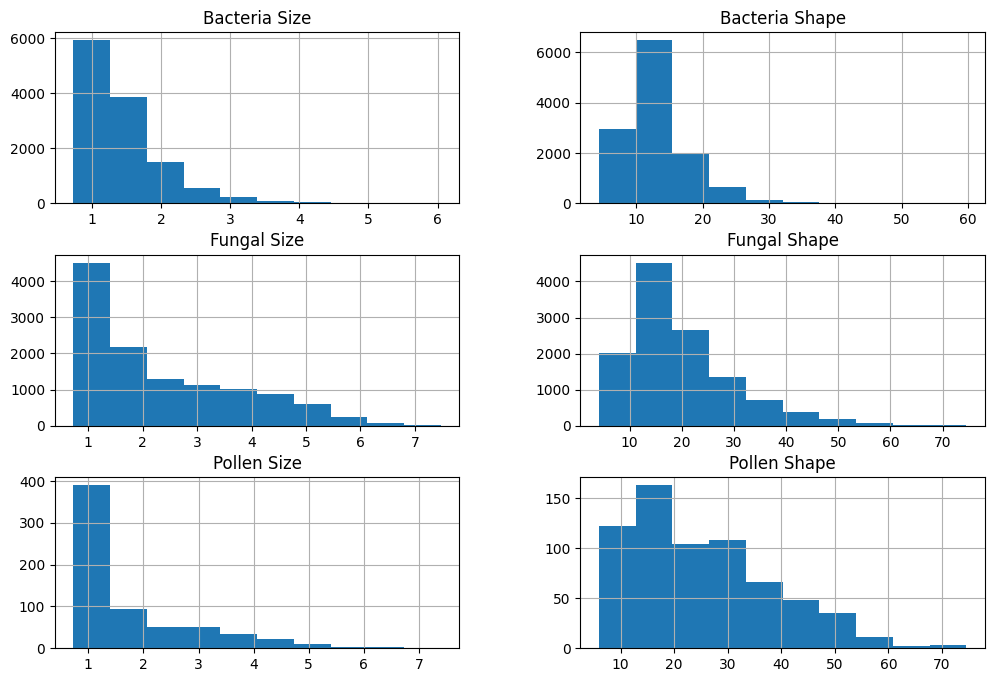

In [3]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharey=False)
# Bacteria
data[data['label'] == 'bacteria'].hist(column='Size',ax=axs[0,0])
data[data['label'] == 'bacteria'].hist(column='Shape',ax=axs[0,1])
# Fungal
data[data['label'] == 'fungal'].hist(column='Size',ax=axs[1,0])
data[data['label'] == 'fungal'].hist(column='Shape',ax=axs[1,1])
# Pollen
data[data['label'] == 'pollen'].hist(column='Size',ax=axs[2,0])
data[data['label'] == 'pollen'].hist(column='Shape',ax=axs[2,1])

axs[0,0].title.set_text('Bacteria Size')
axs[0,1].title.set_text('Bacteria Shape')

axs[1,0].title.set_text('Fungal Size')
axs[1,1].title.set_text('Fungal Shape')

axs[2,0].title.set_text('Pollen Size')
axs[2,1].title.set_text('Pollen Shape')


We see that data from each particle type have qualitatively quite similar profiles. How might we visualise the flourescence spectra? I suggest we produce a boxplot of data from each channel as a function of label in the first exercise below.

<div class="alert alert-block alert-success">
<b> Exercise 1: Produce a boxplot of flourescence spectra as a function of aerosol type <a name="Exercise1"></a>  </b> 

In the code box below, we have provided you with a template for again producing figures on three rows, corresponding to the three distinct labels. The code is incomplete. We need to produce a boxplot of data from the following columns:
    
    XE1_all, XE2_all, XE3_all, XE4_all, XE5_all, XE6_all, XE7_all, XE8_all
    
When complete, your plot should resemble the following figure:
    
![](images/cluster1.png) 

<div class="alert alert-block alert-warning">
<b>Please note:</b> For each boxplot you will need to change the values within the command:

```python
ax=axs[0]
```
where the value in the square brackets indicates the subplot number.

</div>

</div>


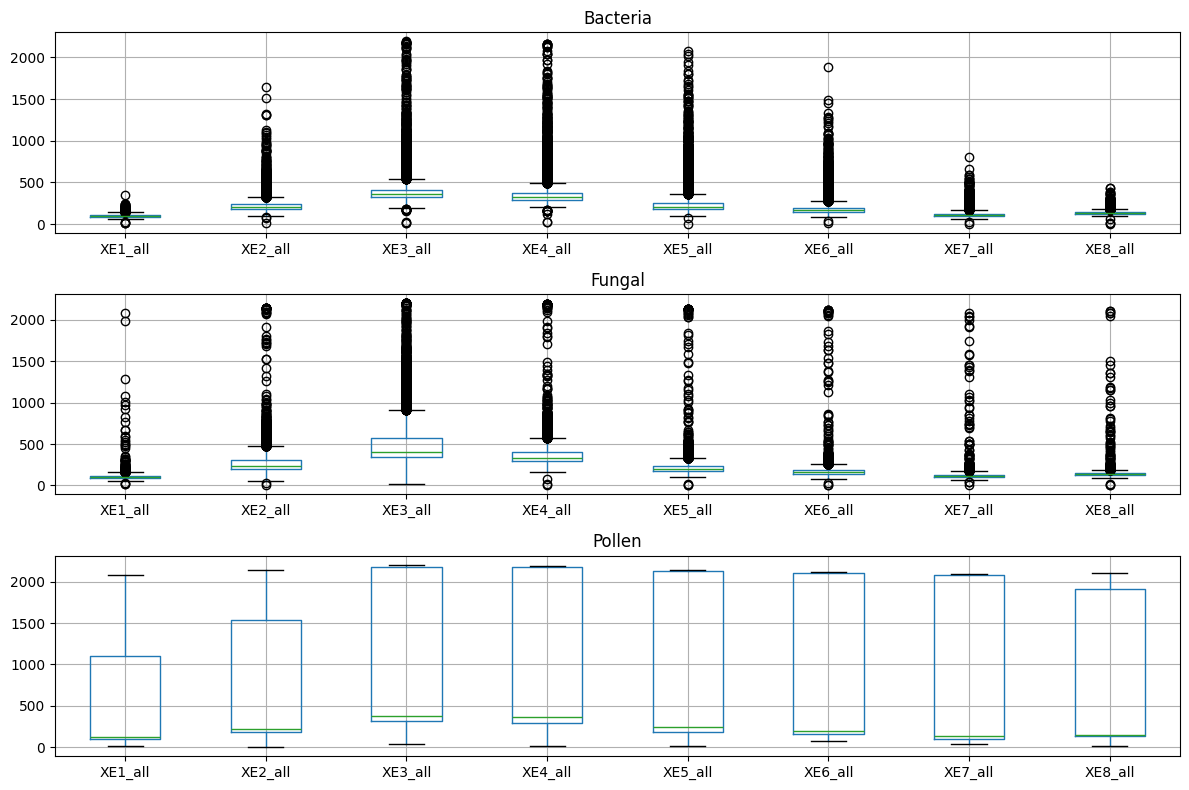

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharey=False)

#------'INSERT CODE HERE'------
# Bacteria
data[data['label'] == 'bacteria'].boxplot(column=["XE1_all", "XE2_all", "XE3_all", "XE4_all", "XE5_all", "XE6_all", "XE7_all", "XE8_all"], ax=axs[0])
# Fungal
data[data['label'] == 'fungal'].boxplot(column=["XE1_all", "XE2_all", "XE3_all", "XE4_all", "XE5_all", "XE6_all", "XE7_all", "XE8_all"], ax=axs[1])
# Pollen
data[data['label'] == 'pollen'].boxplot(column=["XE1_all", "XE2_all", "XE3_all", "XE4_all", "XE5_all", "XE6_all", "XE7_all", "XE8_all"], ax=axs[2])

#------------------------------

axs[0].title.set_text('Bacteria')
axs[1].title.set_text('Fungal')
axs[2].title.set_text('Pollen')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"


<div class="alert alert-block alert-success">
<b> Exercise 2: Produce a boxplot of normalised flourescence spectra as a function of aerosol type <a name="Exercise2"></a>  </b> 

In the following code I have decided its likely easier to visualise the flourescence data normalise to each particle. In other words, let us visualise the variation in flourescence intensity where each channel, thus <code> XE1 </code> etc, for each particle has been normalised to the total intensity for that particle. I import two additional modules to help us with this task: Numpy and Scikit-learn.  If you recall from the previous notebook, we can add additional columns into our dataframe quite easily. In this instance I extract existing flourescence intensity values from our dataframe and then apply a simple normalisation to this 2D array of values. I then enter each column of this new 2D array into new columns in our dataframe. If this part of the code does not make sense, do ask. Once you have completed the task above, repeat this here but display the data from our normalised dataset. Once complete, your figure should look like the following:

![](images/cluster2.png) 

<div class="alert alert-block alert-warning">
<b>Please note:</b> For each boxplot you will need to change the values within the command:

```python
ax=axs[0]
```
where the value in the square brackets indicates the subplot number.

</div>

</div>



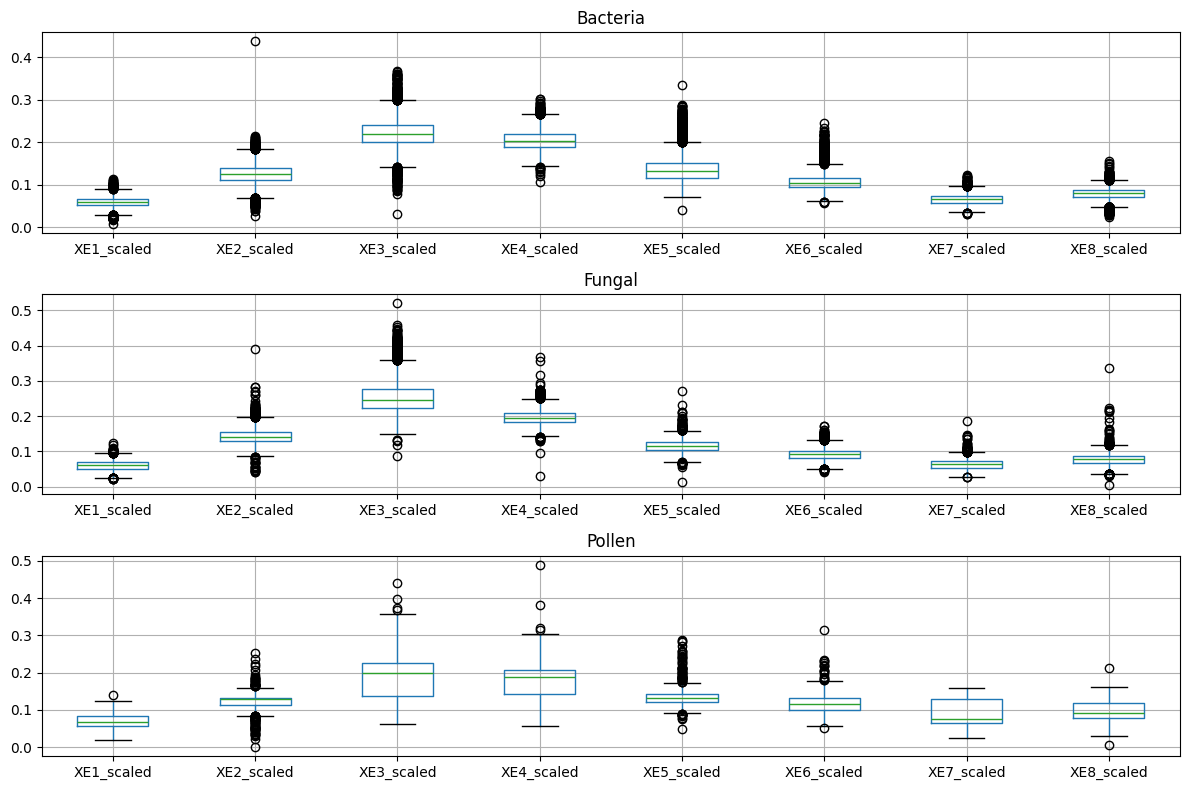

In [9]:
from sklearn.preprocessing import Normalizer
import numpy as np

# Extract the Flourescence data from our dataframe
array = data[['XE1_all','XE2_all','XE3_all','XE4_all','XE5_all','XE6_all','XE7_all','XE8_all']].values
# Sum each row
row_sums = array.sum(axis=1)
# Divide the current 2D array with the total from each row.
# The np.newaxis command simply changes the dimensions of row_sums from (24815) to (24815,1) so we can do the one line division operation
scaled = array / row_sums[:, np.newaxis]
# enter the new data as new columns into the dataframe
data['XE1_scaled'] = scaled[:,0]
data['XE2_scaled'] = scaled[:,1] 
data['XE3_scaled'] = scaled[:,2] 
data['XE4_scaled'] = scaled[:,3] 
data['XE5_scaled'] = scaled[:,4] 
data['XE6_scaled'] = scaled[:,5] 
data['XE7_scaled'] = scaled[:,6] 
data['XE8_scaled'] = scaled[:,7] 

# Now produce boxplots of data for each particle label
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharey=False)
#------'INSERT CODE HERE'------
# Bacteria
data[data['label'] == 'bacteria'].boxplot(column=["XE1_scaled", "XE2_scaled", "XE3_scaled", "XE4_scaled", "XE5_scaled", "XE6_scaled", "XE7_scaled", "XE8_scaled"], ax=axs[0])
# Fungal
data[data['label'] == 'fungal'].boxplot(column=["XE1_scaled", "XE2_scaled", "XE3_scaled", "XE4_scaled", "XE5_scaled", "XE6_scaled", "XE7_scaled", "XE8_scaled"], ax=axs[1])
# Pollen
data[data['label'] == 'pollen'].boxplot(column=["XE1_scaled", "XE2_scaled", "XE3_scaled", "XE4_scaled", "XE5_scaled", "XE6_scaled", "XE7_scaled", "XE8_scaled"], ax=axs[2])

#------------------------------
axs[0].title.set_text('Bacteria')
axs[1].title.set_text('Fungal')
axs[2].title.set_text('Pollen')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"


## K-means

K-means cluster analysis is perhaps the simplest of all clustering algorithms. However, it allows us to practice turning a dataset into one that contains a different number of clusters, members of which should have 'similar' properties. How we define the similarity between members can vary widely. Take the following [figure](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html):

![](images/Practical_8_blue_kmeans.png ) 

For this hypothetical 2D dataset, we can perhaps confidently calculate the correct number of clusters as 4. But, what if we simply dont know how many clusters we need or can't easily visualise all of the dimensions in our dataset? For our dataset, we can at least specify a number of clusters and then visualise the properties of said clusters.  

In the following code snippet we perform a number of steps to fit the K-means clustering algorithm to our priginal dataset and then evaluate its ability to pull out 3 distinct clusters. I'm also going to start talking about 'features' rather than variables in our dataset:

<div class="alert alert-block alert-info">
    
 - Extract our features of interest (Flourescence) from the dataframe into a new Numpy matrix
    
 - Specify how many clusters we want the Kmeans algorithm to find
 
 - Fit the clustering algorithm to our Numpy matrix
 
 - Extract the labels to which each row in our matrix has been assigned.

 - Add these new labels as a new column into our dataframe

</div>

In [10]:
from sklearn.cluster import KMeans
# Extract our variables of interest from the dataframe into a new Numpy matrix
numpy_matrix = data[['XE1_all','XE2_all','XE3_all','XE4_all','XE5_all','XE6_all','XE7_all','XE8_all']].values
# Specify how many clusters we want the Kmeans algorithm to find
clusterer=KMeans(n_clusters=3)
# Fit the clustering algorithm to our Numpy matrix
clusterer.fit(numpy_matrix)
# Extract the labels to which each row in our matrix has been assigned.
labels = clusterer.labels_

# In the dataframe 'data' we can store the labels from using K-means:
data['K-means label'] = labels
# For example the following simply prints the new dataframe column to the screen
data['K-means label']

c:\Users\so19658\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0        2
1        0
2        0
3        0
4        2
        ..
24810    0
24811    0
24812    0
24813    0
24814    0
Name: K-means label, Length: 24815, dtype: int32

Now let us look at the properties of these clusters by generating box-plots of values from our dataframe. We have already produced boxplots, but now we want to produce a plot using the output from K-means. Again, we have 3 labels. In this case we are asking Pandas to produce a boxplot of values seperated by the column <code> K-means label </code>.

Please check the following code snippet and then the box-plots. Do the collected properties of the different clusters allow you to distinguish bettwen them? Do they 'look' different?

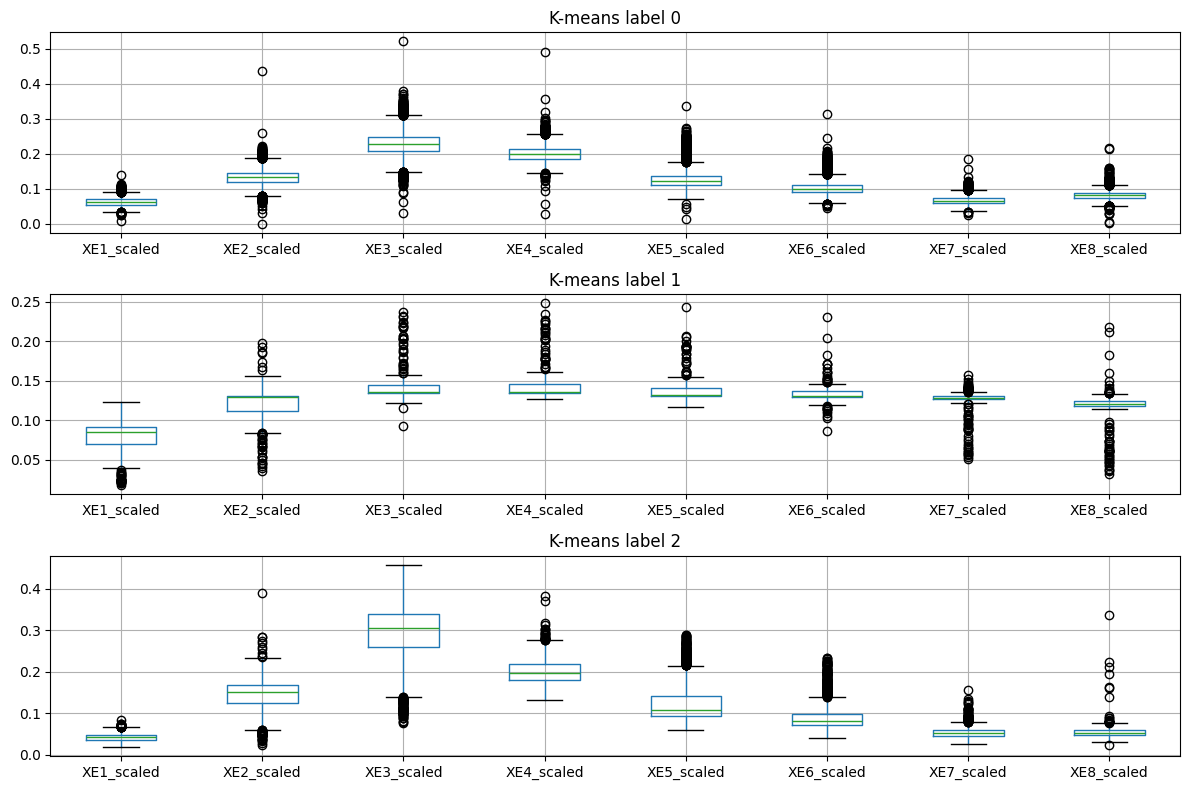

In [11]:
# Now produce boxplots of data for each particle label
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharey=False)
# Bacteria
data[data['K-means label'] == 0].boxplot(column=['XE1_scaled','XE2_scaled','XE3_scaled','XE4_scaled','XE5_scaled','XE6_scaled','XE7_scaled','XE8_scaled'], ax=axs[0])
# Fungal
data[data['K-means label'] == 1].boxplot(column=['XE1_scaled','XE2_scaled','XE3_scaled','XE4_scaled','XE5_scaled','XE6_scaled','XE7_scaled','XE8_scaled'], ax=axs[1])
# Pollen
data[data['K-means label'] == 2].boxplot(column=['XE1_scaled','XE2_scaled','XE3_scaled','XE4_scaled','XE5_scaled','XE6_scaled','XE7_scaled','XE8_scaled'], ax=axs[2])
axs[0].title.set_text('K-means label 0')
axs[1].title.set_text('K-means label 1')
axs[2].title.set_text('K-means label 2')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"


Something is not quite right. One of the cluster profiles seems to be relatively 'flat' compared to the other two. It is likely that K-means is struggling to group data correctly. Whilst I have focused on the algorithm, this could also be a sympton of how we have input the data.

<div class="alert alert-block alert-success">
<b> Exercise 3: Perform and evaluate basic K-means cluster analysis on normalised data <a name="Exercise3"></a>  </b> 
    
In this exercise you can copy the above code example, but you are now tasked with using K-means on the normalised data. Does this have any impact on the profiles of each cluster? No code is given below, but you have all the information you need in this notebook to proceed.
    
Tip: When adding more and more data into a dataframe, the choice of names for each column can be important.

</div>


c:\Users\so19658\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


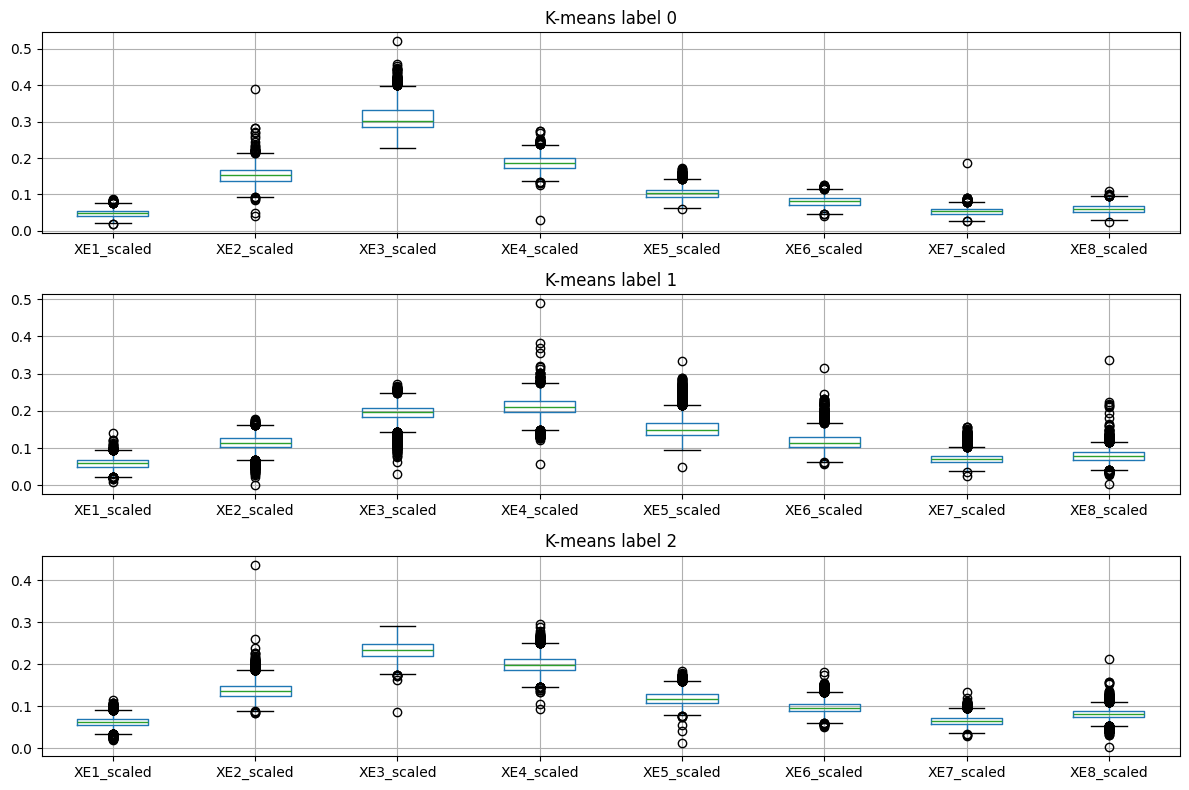

In [20]:
#-------'INSERT CODE HERE'-------
# Extract our variables of interest from the dataframe into a new Numpy matrix
numpy_matrix = data[['XE1_scaled','XE2_scaled','XE3_scaled','XE4_scaled','XE5_scaled','XE6_scaled','XE7_scaled','XE8_scaled']].values
# Specify how many clusters we want the Kmeans algorithm to find
clusterer=KMeans(n_clusters=3)
# Fit the clustering algorithm to our Numpy matrix
clusterer.fit(numpy_matrix)
# Extract the labels to which each row in our matrix has been assigned.
labels = clusterer.labels_
# In the dataframe 'data' we can store the labels from using K-means:
data['K-means label norm'] = labels
# For example the following simply prints the new dataframe column to the screen
data['K-means label norm']
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharey=False)
# Bacteria
data[data['K-means label norm'] == 0].boxplot(column=['XE1_scaled','XE2_scaled','XE3_scaled','XE4_scaled','XE5_scaled','XE6_scaled','XE7_scaled','XE8_scaled'], ax=axs[0])
# Fungal
data[data['K-means label norm'] == 1].boxplot(column=['XE1_scaled','XE2_scaled','XE3_scaled','XE4_scaled','XE5_scaled','XE6_scaled','XE7_scaled','XE8_scaled'], ax=axs[1])
# Pollen
data[data['K-means label norm'] == 2].boxplot(column=['XE1_scaled','XE2_scaled','XE3_scaled','XE4_scaled','XE5_scaled','XE6_scaled','XE7_scaled','XE8_scaled'], ax=axs[2])
axs[0].title.set_text('K-means label 0')
axs[1].title.set_text('K-means label 1')
axs[2].title.set_text('K-means label 2')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
#--------------------------------

### Evaluating the predictions 

Now that we have data from two attempts at K-means clustering, we can try to derive a metric that quantifies the accuracy of at least partitioning observations into the correct groupings. If we were using supervised classification algorithms, we would be able to compare the same labels from our data and those predicted. However in this instance, unsupervised algorithms split the observations into groups but these groups have no labels. In an ideal world, if we had 3500 observations of pollens, we would like to see an identifical number in one of the groups that K-means assigns observations to. However that group label could be anything. So, in this case, what we can do is search through each K-means label and see how many pollens, spores and bacteria have been grouped into each K-means label. Ideally, we would like to see a clear seperation, but we can expect some 'contamination' of group members. For this task, Im going to use the <code> .plot </code> function of the dataframe and then proceed with a bar plot. What do you take from the figures?

<Axes: title={'center': 'Cluster 2'}, xlabel='label'>

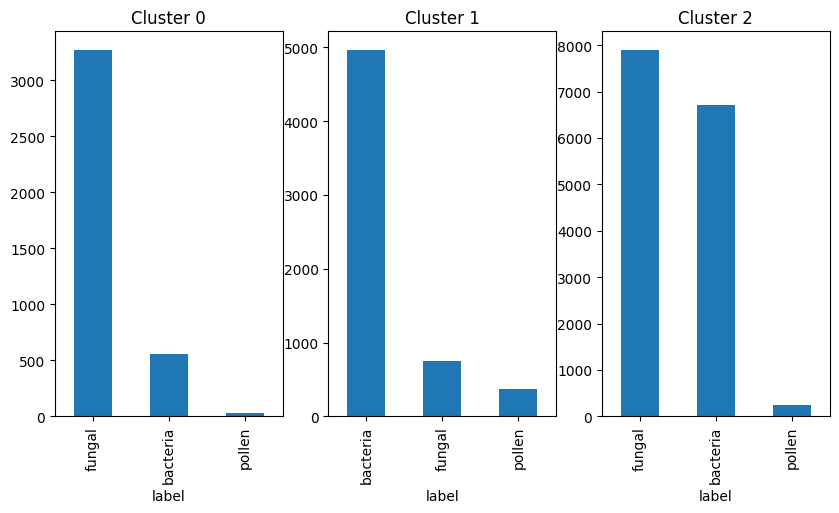

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# Produce 4 seperate plots
data[data['K-means label']==0]['label'].value_counts().plot(kind='bar', title='Cluster 0', ax=axes[0])
data[data['K-means label']==1]['label'].value_counts().plot(kind='bar', title='Cluster 1', ax=axes[1])
data[data['K-means label']==2]['label'].value_counts().plot(kind='bar', title='Cluster 2', ax=axes[2])

<div class="alert alert-block alert-success">
<b> Exercise 4: Exercise 4: Compare cluster membership on normalised data <a name="Exercise4"></a>  </b> 
    
In this exercise you can copy the above code example, but you are now tasked with using the normalised data. Does this have any impact on the profiles of each cluster membership? No code is given below, but you have all the information you need in this notebook to proceed.
    
</div>


<Axes: title={'center': 'Cluster 2'}, xlabel='label'>

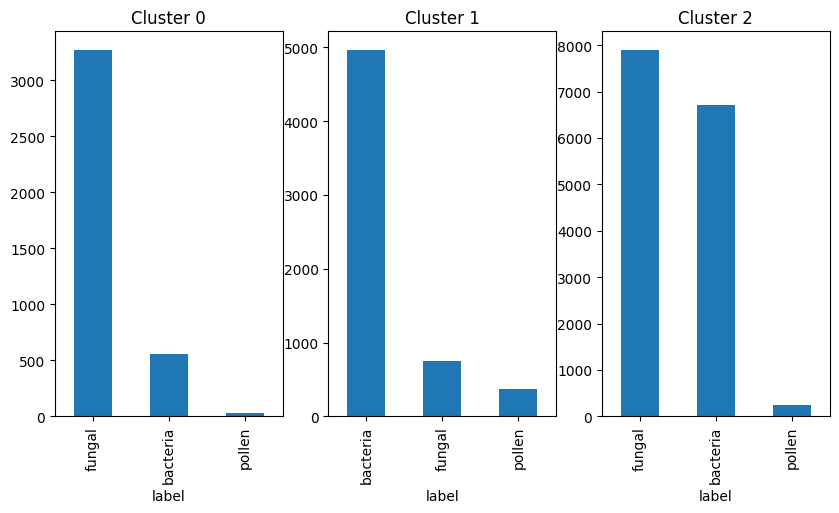

In [30]:
#-------'INSERT CODE HERE'-------
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# Produce 4 seperate plots
data[data['K-means label norm']==0]['label'].value_counts().plot(kind='bar', title='Cluster 0', ax=axes[0])
data[data['K-means label norm']==1]['label'].value_counts().plot(kind='bar', title='Cluster 1', ax=axes[1])
data[data['K-means label norm']==2]['label'].value_counts().plot(kind='bar', title='Cluster 2', ax=axes[2])
#--------------------------------

It would appear that using the normalised data does lead to a clearer seperation between members of each cluster. Specifically you should be able to see the bacteria and fungal spores are better seperated. However, there is significant crossover in one cluster and we do have a problem with our pollens. What else can we try?

<div class="alert alert-block alert-success">
<b> Exercise 5: Add shape into the cluster analysis <a name="Exercise5"></a>  </b> 
    
In this exercise we ask you to now include particle shape into the entire workflow in the code box below. In other words, can you add particle shape into the cluster analysis using both the 'raw' and normalised flourescence data? Once you have create two more sets of labels, please proceed to visualise the cluster membership again. Once complete, you should find your cluster membership for the normalised data plus shape information will resemble the following graph though ordering may be different.
   
![](images/cluster3.png) 
    
Where does this leave us? We will discuss in class.
    
</div>

c:\Users\so19658\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\so19658\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: title={'center': 'Cluster 2'}, xlabel='label'>

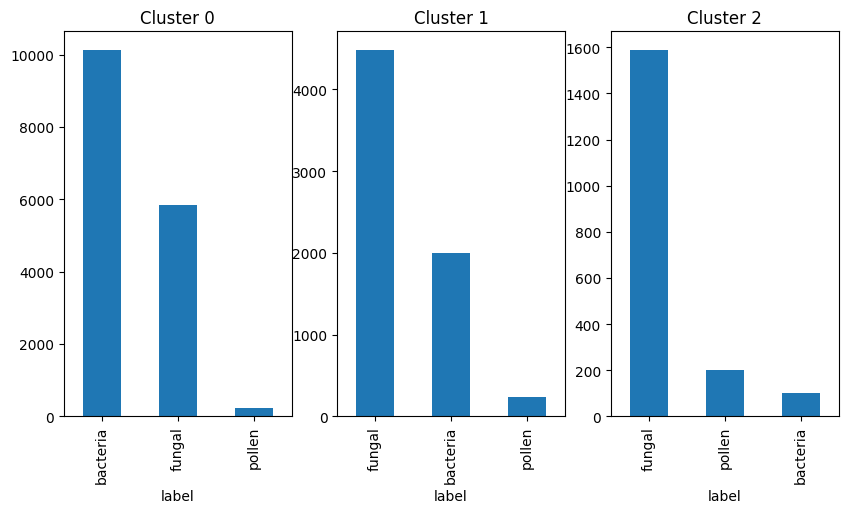

In [35]:
#-------'INSERT CODE HERE'-------
from sklearn.cluster import KMeans
# Extract our variables of interest from the dataframe into a new Numpy matrix
# Set numpy_matrix1 to include raw data and shape
# Set numpy_matrix2 to include normalised data and shape
numpy_matrix1 =  data[['XE1_all','XE2_all','XE3_all','XE4_all','XE5_all','XE6_all','XE7_all','XE8_all',"Shape"]].values
numpy_matrix2 =  data[['XE1_scaled','XE2_scaled','XE3_scaled','XE4_scaled','XE5_scaled','XE6_scaled','XE7_scaled','XE8_scaled',"Shape"]].values
# Specify how many clusters we want the Kmeans algorithm to find
clusterer=KMeans(n_clusters=3)

# Fit the clustering algorithm to our Numpy matrix
clusterer.fit(numpy_matrix1)
# Extract the labels to which each row in our matrix has been assigned.
labels = clusterer.labels_
# In the dataframe 'data' we can store the labels from using K-means:
data['K-means label +shape'] = labels

# Fit the clustering algorithm to our Numpy matrix
clusterer.fit(numpy_matrix2)
# Extract the labels to which each row in our matrix has been assigned.
labels = clusterer.labels_
# In the dataframe 'data' we can store the labels from using K-means:
data['K-means label norm +shape'] = labels

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# Produce 3 seperate plots
data[data['K-means label norm +shape']==0]['label'].value_counts().plot(kind='bar', title='Cluster 0', ax=axes[0])
data[data['K-means label norm +shape']==1]['label'].value_counts().plot(kind='bar', title='Cluster 1', ax=axes[1])
data[data['K-means label norm +shape']==2]['label'].value_counts().plot(kind='bar', title='Cluster 2', ax=axes[2])

#--------------------------------
